Eigenvalues of Jacobian 1: [-0.26957333+0.26557001j -0.26957333-0.26557001j]
time for sim =  0.019461870193481445 s
Eigenvalues of Jacobian 2: [0.01205333+0.37822206j 0.01205333-0.37822206j]


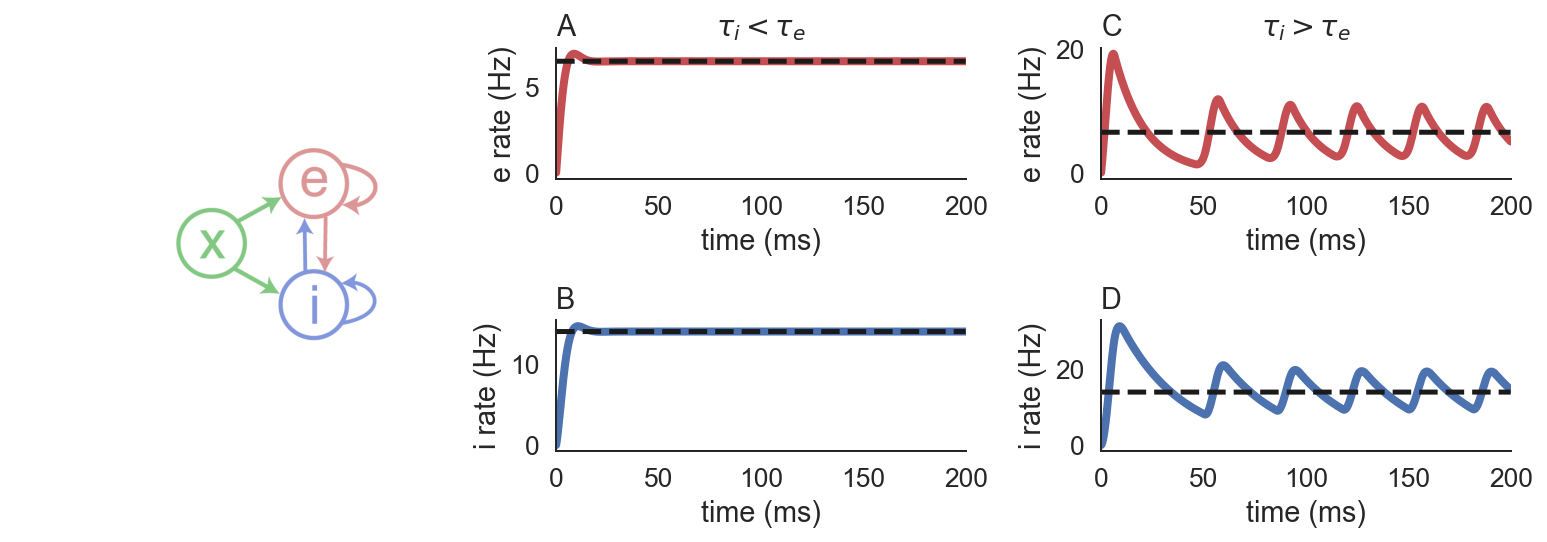

In [1]:
###############################################
## Import packages and specify some settings ##
###############################################
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This makes plots show up and look nice
%matplotlib inline
sns.set(context='paper',style='white',font_scale=1.5,rc={"lines.linewidth":2.5})
sns.set_palette('muted')
%config InlineBackend.figure_format = 'retina'

###############################################
###############################################

# For computing runtimes
from time import time as tm

# Seed random number generator so that
# we get the same results every time
# we run this code
np.random.seed(6)

# Discretized time
T=200
dt=.1
time=np.arange(0,T,dt)
Nt=len(time)

# Use parameters from old spiking network simulations 
# to build W. This way, the fixed point rates will
# approximate steady-state rates in spiking net sims
# Number of external, exc and inh neurons
Nx=800
Ne=800
Ni=200
jex=30
jix=20
jee=12
jei=-45
jie=35
jii=-70
pex=.2
pix=.2
pee=.2 
pei=.2 
pie=.2 
pii=.2
rx=5/1000
wex=jex*pex*Nx 
wix=jix*pix*Nx 
Wx=np.array([wex,wix])

# Entries of W 
wee=jee*pee*Ne 
wei=jei*pei*Ni 
wie=jie*pie*Ne
wii=jii*pii*Ni 
W=np.array([[wee, wei],  [wie, wii]])

# Mean-field external input
Xe=wex*rx
Xi=wix*rx
X=np.array([Xe,Xi])

# Time constants for rate equation
taue=30
taui=15
tau=np.array([taue,taui])


# g and theta from the fit in EIFficurve.ipynb
g = 0.00358
theta = 9.64

rFixedPoint=np.linalg.inv((1/g)*np.eye(2)-W)@(X-theta)


# Define f-I curve
def f(I):
    return g*(I-theta)*(I>theta)


# Define the  Jacobian
J=np.array([[(g*wee-1)/taue, g*wei/taue],[g*wie/taui, (g*wii-1)/taui]])#(1/tau)*(-np.eye(2)+g*W)
lam,_=np.linalg.eig(J)
print('Eigenvalues of Jacobian 1:',lam)

# Initialize rate
re=np.zeros(Nt)
ri=np.zeros(Nt)

# Euler loop
t0=tm()
for i in range(len(time)-1):
    re[i+1]=re[i]+(dt/taue)*(-re[i]+f(wee*re[i]+wei*ri[i]+Xe))
    ri[i+1]=ri[i]+(dt/taui)*(-ri[i]+f(wie*re[i]+wii*ri[i]+Xi))
    
print('time for sim = ',tm()-t0,'s')



# Now re-run with excitation faster
taue2=15
taui2=30
tau2=np.array([taue2,taui2])

# Initialize rate
re2=np.zeros(Nt)
ri2=np.zeros(Nt)

# Euler loop
t0=tm()
for i in range(len(time)-1):
    re2[i+1]=re2[i]+(dt/taue2)*(-re2[i]+f(wee*re2[i]+wei*ri2[i]+Xe))
    ri2[i+1]=ri2[i]+(dt/taui2)*(-ri2[i]+f(wie*re2[i]+wii*ri2[i]+Xi))


# Define the  Jacobian and compute eigenvalues
J2=np.array([[(g*wee-1)/taue2, g*wei/taue2],[g*wie/taui2, (g*wii-1)/taui2]])
lam2,_=np.linalg.eig(J2)
print('Eigenvalues of Jacobian 2:',lam2)


# Make figure
plt.subplots(figsize=(11, 4))

plt.subplot(1,3,1)
# Get image for plot
try: 
    im = plt.imread('./ImageFiles/EIRecurrentNet.png')
except:
    try:
        url = "https://raw.githubusercontent.com/RobertRosenbaum/ModelingNeuralCircuits/master/CodeFromBook/ImageFiles/EIRecurrentNet.png"
        file = np.DataSource().open(url)
        im = plt.imread(file.name)
    except:
        im = 1.0+np.zeros([100,100,3],dtype=np.uint8)
plt.imshow(im,interpolation='hanning',extent=(.4,.9,.25,.75))
plt.axis((0,1,0,1))
plt.axis('off')
#plt.title('A',loc='left')

plt.subplot(2,3,2)
plt.plot(time,1000*re,'r',lw=4)
plt.plot(time,1000*rFixedPoint[0]+np.zeros_like(time),'k--')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('e rate (Hz)')
plt.title(r'$\tau_i<\tau_e$')
plt.title('A',loc='left')
sns.despine()

plt.subplot(2,3,5)
plt.plot(time,1000*ri,'b',lw=4)
plt.plot(time,1000*rFixedPoint[1]+np.zeros_like(time),'k--')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('i rate (Hz)')
plt.title('B',loc='left')
sns.despine()

plt.subplot(2,3,3)
plt.plot(time,1000*re2,'r',lw=4)
plt.plot(time,1000*rFixedPoint[0]+np.zeros_like(time),'k--')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('e rate (Hz)')
plt.title(r'$\tau_i>\tau_e$')
plt.title('C',loc='left')
sns.despine()

plt.subplot(2,3,6)
plt.plot(time,1000*ri2,'b',lw=4)
plt.plot(time,1000*rFixedPoint[1]+np.zeros_like(time),'k--')
plt.xlim([0,T])
plt.xlabel('time (ms)')
plt.ylabel('i rate (Hz)')
plt.title('D',loc='left')
sns.despine()


plt.tight_layout()
